# Geometry File Parsing

In [ ]:
# Uncomment to install/upgrade ras-commander from pip
#!pip install --upgrade ras-commander

#Import the ras-commander package
from ras_commander import *

##### Optional Code Cell For Development/Testing Mode (Local Copy)
##### Uncomment and run this cell instead of the pip cell above

# For Development Mode, add the parent directory to the Python path
import os
import sys
from pathlib import Path

current_file = Path(os.getcwd()).resolve()
rascmdr_directory = current_file.parent

# Use insert(0) instead of append() to give highest priority to local version
if str(rascmdr_directory) not in sys.path:
    sys.path.insert(0, str(rascmdr_directory))

print("Loading ras-commander from local dev copy")
from ras_commander import *

# Complete Guide to HEC-RAS Geometry Operations

This notebook demonstrates comprehensive geometry parsing and manipulation capabilities using the RasGeometry and HdfHydraulicTables classes. We'll explore how to extract, analyze, and modify various geometry types from HEC-RAS files.

## Operations Covered

1. **Cross Section Operations**: Extract and modify station/elevation data
2. **Hydraulic Property Tables (HTAB)**: Generate rating curves from preprocessed geometry
3. **Storage Areas**: Extract elevation-volume curves for reservoirs and detention basins
4. **Lateral Structures**: Analyze overflow weirs and lateral connections
5. **SA/2D Connections**: Extract dam breach connections, weir profiles, and gates
6. **Batch Processing**: Automate operations across multiple geometry elements

These capabilities enable:
- Automated geometry modification for sensitivity studies
- Rating curve generation without re-running HEC-RAS
- Dam breach and detention basin analysis
- Model setup validation and QA/QC

## Package Setup and Imports

In [2]:
# Import required libraries
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Add ras-commander to path (for local development)
current_file = Path.cwd()
ras_commander_root = current_file.parent
sys.path.insert(0, str(ras_commander_root))

# Import RAS Commander geometry modules
from ras_commander import (
    RasGeometry,
    RasGeometryUtils,
    HdfHydraulicTables,
    RasExamples,
    init_ras_project,
    RasCmdr,
    ras
)

print("✓ Packages loaded successfully!")
print(f"Working directory: {Path.cwd()}")

✓ Packages loaded successfully!
Working directory: c:\GH\ras-commander\examples


## Section 1: Cross Section Operations

Cross sections define the channel geometry in 1D models. We'll explore how to list cross sections, extract their station/elevation data, and modify them.

In [3]:
bald_eagle_path = RasExamples.extract_project("Balde Eagle Creek")
print(bald_eagle_path)
init_ras_project(bald_eagle_path)

2025-12-02 21:27:20 - ras_commander.RasExamples - INFO - Found zip file: c:\GH\ras-commander\examples\Example_Projects_6_6.zip
2025-12-02 21:27:20 - ras_commander.RasExamples - INFO - Loading project data from CSV...
2025-12-02 21:27:20 - ras_commander.RasExamples - INFO - Loaded 68 projects from CSV.
2025-12-02 21:27:20 - ras_commander.RasExamples - INFO - ----- RasExamples Extracting Project -----
2025-12-02 21:27:20 - ras_commander.RasExamples - INFO - Extracting project 'Balde Eagle Creek'
2025-12-02 21:27:20 - ras_commander.RasExamples - INFO - Project 'Balde Eagle Creek' already exists. Deleting existing folder...
2025-12-02 21:27:20 - ras_commander.RasExamples - INFO - Existing folder for project 'Balde Eagle Creek' has been deleted.
2025-12-02 21:27:20 - ras_commander.RasExamples - INFO - Successfully extracted project 'Balde Eagle Creek' to c:\GH\ras-commander\examples\example_projects\Balde Eagle Creek
2025-12-02 21:27:20 - ras_commander.RasPrj - INFO - No HEC-RAS Version Spe

c:\GH\ras-commander\examples\example_projects\Balde Eagle Creek


In [4]:
ras.plan_df

,plan_number,unsteady_number,geometry_number,Plan Title,Program Version,Short Identifier,Simulation Date,Computation Interval,Mapping Interval,Run HTab,...,PS Cores,DSS File,Friction Slope Method,HDF_Results_Path,Geom File,Geom Path,Flow File,Flow Path,full_path,flow_type
0,01,02,01,Unsteady with Bridges and Dam,5.00,UnsteadyFlow,"18FEB1999,0000,24FEB1999,0500",2MIN,1HOUR,1,...,None,dss,2,None,01,C:\GH\ras-commander\examples\example_projects\...,02,C:\GH\ras-commander\examples\example_projects\...,C:\GH\ras-commander\examples\example_projects\...,Unsteady
1,02,None,01,Steady Flow Run,NaN,SteadyRun,"02/18/1999,0000,02/24/1999,0500",2MIN,NaN,1,...,None,dss,1,None,01,C:\GH\ras-commander\examples\example_projects\...,02,C:\GH\ras-commander\examples\example_projects\...,C:\GH\ras-commander\examples\example_projects\...,Steady


In [5]:
ras.geom_df

,geom_file,geom_number,full_path,hdf_path
0,g01,01,C:\GH\ras-commander\examples\example_projects\...,C:\GH\ras-commander\examples\example_projects\...


### 1.1 Setup: Define Geometry File Path

In [6]:
# Lookup geometry file path and HDF path from ras.geom_df by geom_number
geom_number = "01"
geom_row = ras.geom_df.loc[ras.geom_df['geom_number'] == geom_number].iloc[0]

geom_file = Path(geom_row["full_path"])
geom_hdf = Path(geom_row["hdf_path"])

print(f"Geometry file: {geom_file}")
print(f"File exists: {geom_file.exists()}")
if geom_file.exists():
    print(f"File size: {geom_file.stat().st_size / 1024:.1f} KB")
else:
    print("Geometry file does not exist!")
print(f"HDF file: {geom_hdf}")
print(f"HDF exists: {geom_hdf.exists()}")

Geometry file: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.g01
File exists: True
File size: 513.6 KB
HDF file: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.g01.hdf
HDF exists: True


### 1.2 List All Cross Sections

In [7]:
# Extract all cross sections
xs_df = RasGeometry.get_cross_sections(geom_file)

print(f"Total cross sections: {len(xs_df)}")
print(f"Rivers: {xs_df['River'].unique().tolist()}")
print(f"Reaches: {xs_df['Reach'].unique().tolist()}")

print("\nFirst 10 cross sections:")
display.display(xs_df)

2025-12-02 21:27:20 - ras_commander.geom.GeomCrossSection - INFO - Extracted 189 cross sections from BaldEagle.g01


Total cross sections: 189
Rivers: ['Bald Eagle']
Reaches: ['Loc Hav']

First 10 cross sections:


,River,Reach,RS,Type,Length_Left,Length_Channel,Length_Right,NodeName
0,Bald Eagle,Loc Hav,138154.4,1,358.43,463.64,517.64,
1,Bald Eagle,Loc Hav,137690.8,1,305.71,363.84,382.83,
2,Bald Eagle,Loc Hav,137327.0,1,732.93,762.02,765.36,
3,Bald Eagle,Loc Hav,136564.9,1,349.61,362.64,370.75,
4,Bald Eagle,Loc Hav,136202.3,1,590.50,610.86,647.38,
...,...,...,...,...,...,...,...,...
184,Bald Eagle,Loc Hav,2436,3,0.00,0.00,0.00,
185,Bald Eagle,Loc Hav,2371.827,1,876.88,679.19,422.71,
186,Bald Eagle,Loc Hav,1692.633,1,576.94,479.78,449.20,
187,Bald Eagle,Loc Hav,1212.855,1,526.27,552.91,604.83,


### 1.3 Extract Station/Elevation for a Cross Section

In [8]:
# Select first cross section
first_xs = xs_df.iloc[0]
river = first_xs['River']
reach = first_xs['Reach']
rs = first_xs['RS']

print(f"Selected cross section: {river} / {reach} / RS {rs}")

# Extract station/elevation data
sta_elev = RasGeometry.get_station_elevation(geom_file, river, reach, rs)

print(f"\nStation/Elevation Data:")
print(f"  Points: {len(sta_elev)}")
print(f"  Station range: {sta_elev['Station'].min():.2f} to {sta_elev['Station'].max():.2f} ft")
print(f"  Elevation range: {sta_elev['Elevation'].min():.2f} to {sta_elev['Elevation'].max():.2f} ft")
print(f"  Channel width: {sta_elev['Station'].max() - sta_elev['Station'].min():.2f} ft")

print("\nFirst 10 points:")
display.display(sta_elev.head(10))

2025-12-02 21:27:20 - ras_commander.geom.GeomCrossSection - INFO - Extracted 40 station/elevation pairs for Bald Eagle/Loc Hav/RS 138154.4


Selected cross section: Bald Eagle / Loc Hav / RS 138154.4

Station/Elevation Data:
  Points: 40
  Station range: 0.00 to 557.01 ft
  Elevation range: 656.30 to 706.27 ft
  Channel width: 557.01 ft

First 10 points:


,Station,Elevation
0,0.0,660.41
1,5.0,660.61
2,40.0,659.85
3,55.0,659.39
4,60.0,659.21
5,90.0,658.45
6,95.0,658.48
7,130.0,659.60
8,190.0,660.21
9,195.0,658.98


### 1.4 Visualize Cross Section Profile

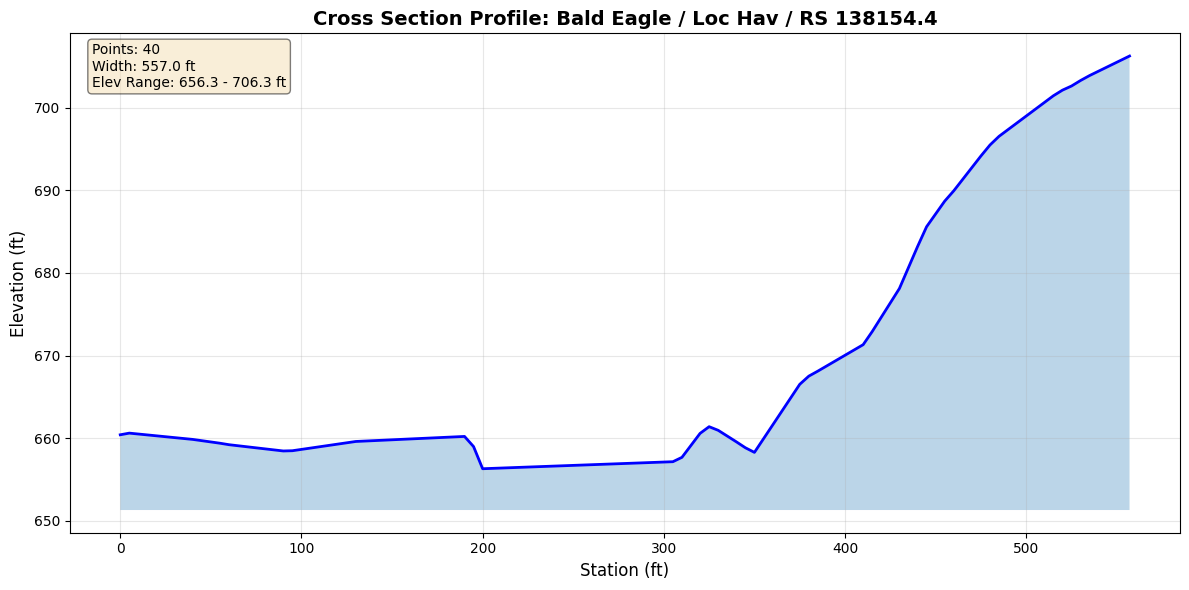

In [9]:
# Plot cross section profile
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(sta_elev['Station'], sta_elev['Elevation'], 'b-', linewidth=2, label='Cross Section')
ax.fill_between(sta_elev['Station'], sta_elev['Elevation'],
                 sta_elev['Elevation'].min() - 5,
                 alpha=0.3)

ax.grid(True, alpha=0.3)
ax.set_xlabel('Station (ft)', fontsize=12)
ax.set_ylabel('Elevation (ft)', fontsize=12)
ax.set_title(f'Cross Section Profile: {river} / {reach} / RS {rs}',
             fontsize=14, fontweight='bold')

# Add statistics annotation
stats_text = f'Points: {len(sta_elev)}\n'
stats_text += f'Width: {sta_elev["Station"].max() - sta_elev["Station"].min():.1f} ft\n'
stats_text += f'Elev Range: {sta_elev["Elevation"].min():.1f} - {sta_elev["Elevation"].max():.1f} ft'
ax.text(0.02, 0.98, stats_text,
        transform=ax.transAxes,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
        fontsize=10)

plt.tight_layout()
plt.show()

### 1.5 Modify Cross Section Geometry (Round-Trip Example)

In [10]:
# NOTE: This cell modifies the geometry file!
# Uncomment to actually modify the file (backup is created automatically)

# # Read original data
# original_sta_elev = RasGeometry.get_station_elevation(geom_file, river, reach, rs)
# print(f"Original mean elevation: {original_sta_elev['Elevation'].mean():.3f} ft")

# # Modify elevations (raise by 1 foot)
# modified_sta_elev = original_sta_elev.copy()
# modified_sta_elev['Elevation'] += 1.0

# # Write back to file (creates .bak backup automatically)
# RasGeometry.set_station_elevation(geom_file, river, reach, rs, modified_sta_elev)
# print(f"\n✓ Modified geometry written to file")
# print(f"  Backup created: {geom_file}.bak")

# # Verify round-trip
# readback_sta_elev = RasGeometry.get_station_elevation(geom_file, river, reach, rs)
# print(f"\nReadback mean elevation: {readback_sta_elev['Elevation'].mean():.3f} ft")
# print(f"Difference: {abs(modified_sta_elev['Elevation'].mean() - readback_sta_elev['Elevation'].mean()):.6f} ft")

# # Restore original (using backup)
# import shutil
# shutil.copy2(str(geom_file) + '.bak', geom_file)
# print(f"\n✓ Original geometry restored from backup")

print("Modification example is commented out to protect geometry file.")
print("Uncomment the code above to test round-trip operations.")

Modification example is commented out to protect geometry file.
Uncomment the code above to test round-trip operations.


## Section 2: Hydraulic Property Tables (HTAB)

Property tables contain preprocessed hydraulic properties (area, conveyance, wetted perimeter, etc.) as functions of elevation. These enable hydraulic analysis without re-running HEC-RAS.

**IMPORTANT:** Property tables only exist in preprocessed geometry HDF files. Run `RasCmdr.compute_plan()` to generate them.

### 2.1 Generate Preprocessed Geometry HDF

In [11]:
# NOTE: This cell runs HEC-RAS and may take 1-2 minutes!
# Uncomment to generate preprocessed HDF

# Extract and initialize project
project_path = RasExamples.extract_project("Balde Eagle Creek")
init_ras_project(project_path, "6.6")

# Compute plan to generate preprocessed geometry HDF
print("Computing plan 01 to generate preprocessed geometry HDF...")
print("(This may take 1-2 minutes)\n")
result = RasCmdr.compute_plan("01")

if result:
    geom_hdf = ras.geom_df.iloc[0]['full_path'] + '.hdf'
    print(f"\n✓ Preprocessed HDF created: {Path(geom_hdf).name}")
    print(f"  Location: {geom_hdf}")
else:
    print("ERROR: Plan computation failed")



2025-12-02 21:27:20 - ras_commander.RasExamples - INFO - ----- RasExamples Extracting Project -----
2025-12-02 21:27:20 - ras_commander.RasExamples - INFO - Extracting project 'Balde Eagle Creek'
2025-12-02 21:27:20 - ras_commander.RasExamples - INFO - Project 'Balde Eagle Creek' already exists. Deleting existing folder...
2025-12-02 21:27:20 - ras_commander.RasExamples - INFO - Existing folder for project 'Balde Eagle Creek' has been deleted.
2025-12-02 21:27:20 - ras_commander.RasExamples - INFO - Successfully extracted project 'Balde Eagle Creek' to c:\GH\ras-commander\examples\example_projects\Balde Eagle Creek
2025-12-02 21:27:21 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.rasmap
2025-12-02 21:27:21 - ras_commander.RasCmdr - INFO - Using ras_object with project folder: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek
2025-12-02 21:27:21 - ras_commander.RasCmdr - INFO - 

Computing plan 01 to generate preprocessed geometry HDF...
(This may take 1-2 minutes)



2025-12-02 21:28:46 - ras_commander.RasCmdr - INFO - HEC-RAS execution completed for plan: 01
2025-12-02 21:28:46 - ras_commander.RasCmdr - INFO - Total run time for plan 01: 85.65 seconds



✓ Preprocessed HDF created: BaldEagle.g01.hdf
  Location: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.g01.hdf


### 2.2 Extract HTAB for a Cross Section

In [12]:
# Extract hydraulic property table
river = "Bald Eagle"
reach = "Loc Hav"
rs = "138154.4"

htab = HdfHydraulicTables.get_xs_htab(geom_hdf, river, reach, rs)

print(f"Hydraulic Property Table for {river} / {reach} / RS {rs}")
print(f"\nTable dimensions: {len(htab)} elevations × {len(htab.columns)} properties")
print(f"Elevation range: {htab['Elevation'].min():.2f} to {htab['Elevation'].max():.2f} ft")

print("\nAvailable properties:")
for col in htab.columns:
    print(f"  - {col}")

print("\nFirst 5 rows:")
display.display(htab.head())

2025-12-02 21:28:46 - ras_commander.hdf.HdfHydraulicTables - INFO - Using HDF file from direct string path: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.g01.hdf
2025-12-02 21:28:46 - ras_commander.hdf.HdfHydraulicTables - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.g01.hdf
2025-12-02 21:28:46 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 51 elevations × 26 properties
2025-12-02 21:28:46 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted HTAB for Bald Eagle/Loc Hav/RS 138154.4: 51 elevations, 26 properties


Hydraulic Property Table for Bald Eagle / Loc Hav / RS 138154.4

Table dimensions: 51 elevations × 26 properties
Elevation range: 656.30 to 705.80 ft

Available properties:
  - Elevation
  - Area_LOB
  - Area_Chan
  - Area_ROB
  - Area_Ineff_LOB
  - Area_Ineff_Chan
  - Area_Ineff_ROB
  - Conv_LOB
  - Conv_Chan
  - Conv_ROB
  - WP_LOB
  - WP_Chan
  - WP_ROB
  - Mann_N_LOB
  - Mann_N_Chan
  - Mann_N_ROB
  - Top_Width
  - Top_Width_LOB
  - Top_Width_Chan
  - Top_Width_ROB
  - Alpha
  - Storage_Area
  - Beta
  - Area_Total
  - Conveyance_Total
  - Wetted_Perimeter_Total

First 5 rows:


,Elevation,Area_LOB,Area_Chan,Area_ROB,Area_Ineff_LOB,Area_Ineff_Chan,Area_Ineff_ROB,Conv_LOB,Conv_Chan,Conv_ROB,...,Top_Width,Top_Width_LOB,Top_Width_Chan,Top_Width_ROB,Alpha,Storage_Area,Beta,Area_Total,Conveyance_Total,Wetted_Perimeter_Total
0,656.299988,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,1.000000,0.0,1.000000,0.000000,0.000000,0.000000
1,656.799988,0.000000,15.674454,0.0,0.000000,15.674454,0.0,0.000000,230.763748,0.0,...,62.697815,0.000000,62.697815,0.0,1.000000,0.0,1.000000,15.674454,230.763748,62.825043
2,657.799988,0.000000,116.927422,0.0,0.000000,116.927422,0.0,0.000000,4426.948730,0.0,...,113.217026,0.000000,113.217026,0.0,1.000000,0.0,1.000000,116.927422,4426.948730,113.641609
3,658.799988,5.692433,234.416946,0.0,5.692433,234.416946,0.0,47.807816,13194.948242,0.0,...,153.563675,28.814926,124.748749,0.0,1.037918,0.0,1.017451,240.109375,13242.755859,154.503967
4,659.799988,69.582207,367.637421,0.0,69.582207,367.637421,0.0,1284.827271,25577.912109,0.0,...,250.028366,108.041672,141.986694,0.0,1.225288,0.0,1.092600,437.219635,26862.740234,251.514709


### 2.3 Generate Rating Curves

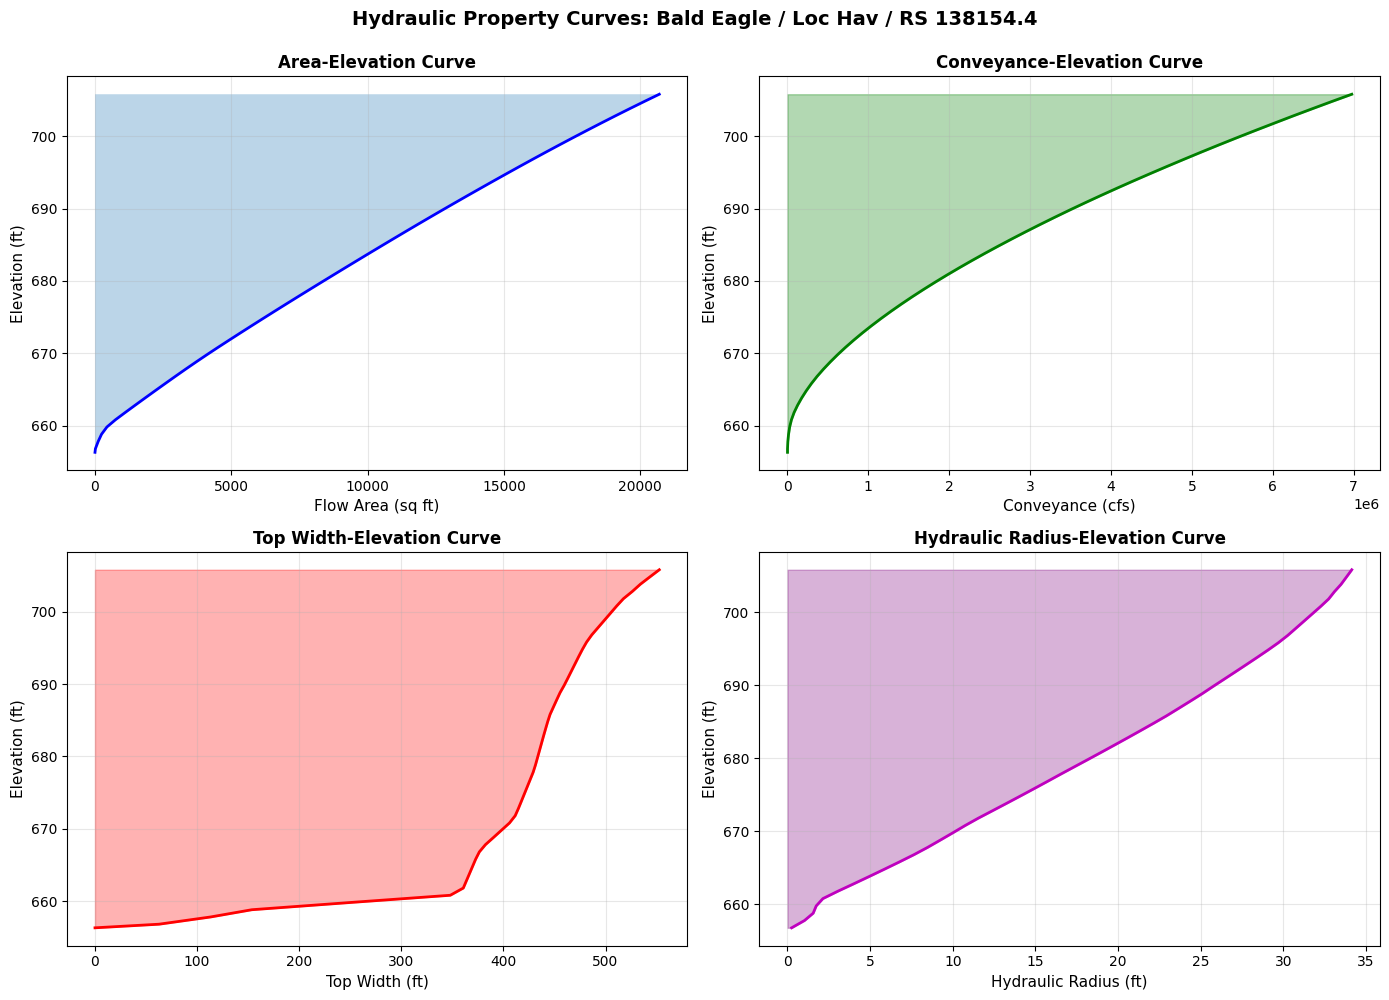


Maximum Hydraulic Properties:
  Max Area: 20701.2 sq ft
  Max Conveyance: 6977025.0 cfs
  Max Hydraulic Radius: 34.14 ft
  Max Top Width: 552.6 ft


In [13]:
# Calculate hydraulic radius
htab['Hydraulic_Radius'] = htab['Area_Total'] / htab['Wetted_Perimeter_Total']
htab['Hydraulic_Radius'] = htab['Hydraulic_Radius'].replace([np.inf, -np.inf], 0)

# Create 4-panel rating curve plot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Area vs Elevation
ax1 = axes[0, 0]
ax1.plot(htab['Area_Total'], htab['Elevation'], 'b-', linewidth=2)
ax1.fill_betweenx(htab['Elevation'], 0, htab['Area_Total'], alpha=0.3)
ax1.set_xlabel('Flow Area (sq ft)', fontsize=11)
ax1.set_ylabel('Elevation (ft)', fontsize=11)
ax1.set_title('Area-Elevation Curve', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Plot 2: Conveyance vs Elevation
ax2 = axes[0, 1]
ax2.plot(htab['Conveyance_Total'], htab['Elevation'], 'g-', linewidth=2)
ax2.fill_betweenx(htab['Elevation'], 0, htab['Conveyance_Total'], alpha=0.3, color='green')
ax2.set_xlabel('Conveyance (cfs)', fontsize=11)
ax2.set_ylabel('Elevation (ft)', fontsize=11)
ax2.set_title('Conveyance-Elevation Curve', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Plot 3: Top Width vs Elevation
ax3 = axes[1, 0]
ax3.plot(htab['Top_Width'], htab['Elevation'], 'r-', linewidth=2)
ax3.fill_betweenx(htab['Elevation'], 0, htab['Top_Width'], alpha=0.3, color='red')
ax3.set_xlabel('Top Width (ft)', fontsize=11)
ax3.set_ylabel('Elevation (ft)', fontsize=11)
ax3.set_title('Top Width-Elevation Curve', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)

# Plot 4: Hydraulic Radius vs Elevation
ax4 = axes[1, 1]
ax4.plot(htab['Hydraulic_Radius'], htab['Elevation'], 'm-', linewidth=2)
ax4.fill_betweenx(htab['Elevation'], 0, htab['Hydraulic_Radius'], alpha=0.3, color='purple')
ax4.set_xlabel('Hydraulic Radius (ft)', fontsize=11)
ax4.set_ylabel('Elevation (ft)', fontsize=11)
ax4.set_title('Hydraulic Radius-Elevation Curve', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)

fig.suptitle(f'Hydraulic Property Curves: {river} / {reach} / RS {rs}',
             fontsize=14, fontweight='bold', y=0.995)

plt.tight_layout()
plt.show()

print("\nMaximum Hydraulic Properties:")
print(f"  Max Area: {htab['Area_Total'].max():.1f} sq ft")
print(f"  Max Conveyance: {htab['Conveyance_Total'].max():.1f} cfs")
print(f"  Max Hydraulic Radius: {htab['Hydraulic_Radius'].max():.2f} ft")
print(f"  Max Top Width: {htab['Top_Width'].max():.1f} ft")

### 2.4 Find Hydraulic Properties at Specific Elevation

In [14]:
# Find properties at specific water surface elevation
target_elev = 665.0

# Find closest elevation in table
idx = (htab['Elevation'] - target_elev).abs().idxmin()
actual_elev = htab.loc[idx, 'Elevation']

print(f"Target elevation: {target_elev:.2f} ft")
print(f"Closest table elevation: {actual_elev:.2f} ft\n")

print(f"Hydraulic properties at elevation {actual_elev:.2f} ft:")
print(f"  Flow Area: {htab.loc[idx, 'Area_Total']:.1f} sq ft")
print(f"  Conveyance: {htab.loc[idx, 'Conveyance_Total']:.1f} cfs")
print(f"  Wetted Perimeter: {htab.loc[idx, 'Wetted_Perimeter_Total']:.1f} ft")
print(f"  Top Width: {htab.loc[idx, 'Top_Width']:.1f} ft")
print(f"  Hydraulic Radius: {htab.loc[idx, 'Hydraulic_Radius']:.2f} ft")
print(f"  Velocity Coefficient (Alpha): {htab.loc[idx, 'Alpha']:.3f}")

Target elevation: 665.00 ft
Closest table elevation: 664.80 ft

Hydraulic properties at elevation 664.80 ft:
  Flow Area: 2202.4 sq ft
  Conveyance: 231547.8 cfs
  Wetted Perimeter: 376.8 ft
  Top Width: 369.8 ft
  Hydraulic Radius: 5.84 ft
  Velocity Coefficient (Alpha): 1.220


### 2.5 Batch Extract HTABs for Multiple Cross Sections

In [15]:
# Extract HTABs for all cross sections
print("Extracting property tables for all cross sections...")
print("(This may take a few seconds)\n")

all_htabs = HdfHydraulicTables.get_all_xs_htabs(geom_hdf)

print(f"Total HTABs extracted: {len(all_htabs)}")

# Calculate statistics across all cross sections
stats_list = []
for (river, reach, rs), htab_df in list(all_htabs.items())[:10]:  # First 10 for demo
    htab_df['Hydraulic_Radius'] = htab_df['Area_Total'] / htab_df['Wetted_Perimeter_Total']
    htab_df['Hydraulic_Radius'] = htab_df['Hydraulic_Radius'].replace([np.inf, -np.inf], 0)

    stats_list.append({
        'RS': rs,
        'Max_Area': htab_df['Area_Total'].max(),
        'Max_Conveyance': htab_df['Conveyance_Total'].max(),
        'Max_Hydraulic_Radius': htab_df['Hydraulic_Radius'].max(),
        'Num_Elevations': len(htab_df)
    })

stats_df = pd.DataFrame(stats_list)

print("\nStatistics for first 10 cross sections:")
display.display(stats_df)

2025-12-02 21:28:47 - ras_commander.hdf.HdfHydraulicTables - INFO - Using HDF file from direct string path: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.g01.hdf
2025-12-02 21:28:47 - ras_commander.hdf.HdfHydraulicTables - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.g01.hdf
2025-12-02 21:28:47 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 51 elevations × 26 properties
2025-12-02 21:28:47 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 67 elevations × 26 properties
2025-12-02 21:28:47 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 68 elevations × 26 properties
2025-12-02 21:28:47 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 40 elevations × 26 properties
2025-12-02 21:28:47 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 41 elevations × 26 properties
2025-12-02 21

Extracting property tables for all cross sections...
(This may take a few seconds)



2025-12-02 21:28:47 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 28 elevations × 26 properties
2025-12-02 21:28:47 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 23 elevations × 26 properties
2025-12-02 21:28:47 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 22 elevations × 26 properties
2025-12-02 21:28:47 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 22 elevations × 26 properties
2025-12-02 21:28:47 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 45 elevations × 26 properties
2025-12-02 21:28:47 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 73 elevations × 26 properties
2025-12-02 21:28:47 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 91 elevations × 26 properties
2025-12-02 21:28:47 - ras_commander.hdf.HdfHydraulicTables - INFO - Extracted property table: 69 elevations × 26 properties
2025-12-

Total HTABs extracted: 178

Statistics for first 10 cross sections:


,RS,Max_Area,Max_Conveyance,Max_Hydraulic_Radius,Num_Elevations
0,138154.4,20701.232422,6977025.00,34.144203,51
1,137690.8,44466.535156,16715759.00,48.128937,67
2,137327.0,45780.699219,17608260.00,50.108379,68
3,136564.9,21783.722656,5806229.50,26.523174,40
4,136202.3,26415.556641,7483566.50,29.737156,41
5,135591.4,14490.575195,2507643.00,15.844055,23
6,135068.7,20730.187500,3290782.25,16.082315,23
7,134487.2,22591.662109,4204560.50,19.019423,26
8,133881.0,23631.132812,4800342.50,20.430098,27
9,133446.1,23645.011719,4819964.00,19.912445,30


-----

## Section 3: Storage Area Operations

Storage areas represent reservoirs, detention basins, or other storage volumes. We'll extract elevation-volume curves that define storage capacity.

### 3.1 List Storage Areas

#### Change to Geometry 12 (SA to 2D Connection) of BaldEagleCrkMulti2D

In [16]:
from pathlib import Path

# Set extraction path for storage area operations
storageareasoperations_path = Path.cwd() / "example_projects" / "StorageAreaOperations"

# Extract the example project to the designated folder
bald_eagle2D_path = RasExamples.extract_project("BaldEagleCrkMulti2D", output_path=storageareasoperations_path)
print(bald_eagle2D_path)

init_ras_project(bald_eagle2D_path)

geom_number = "12"
geom_row = ras.geom_df.loc[ras.geom_df['geom_number'] == geom_number].iloc[0]

geom_file = Path(geom_row["full_path"])
geom_hdf = Path(geom_row["hdf_path"])

2025-12-02 21:28:47 - ras_commander.RasExamples - INFO - ----- RasExamples Extracting Project -----
2025-12-02 21:28:47 - ras_commander.RasExamples - INFO - Extracting project 'BaldEagleCrkMulti2D'
2025-12-02 21:28:47 - ras_commander.RasExamples - INFO - Project 'BaldEagleCrkMulti2D' already exists. Deleting existing folder...
2025-12-02 21:28:47 - ras_commander.RasExamples - INFO - Existing folder for project 'BaldEagleCrkMulti2D' has been deleted.
2025-12-02 21:28:48 - ras_commander.RasExamples - INFO - Successfully extracted project 'BaldEagleCrkMulti2D' to c:\GH\ras-commander\examples\example_projects\StorageAreaOperations\BaldEagleCrkMulti2D
2025-12-02 21:28:48 - ras_commander.RasPrj - INFO - No HEC-RAS Version Specified.Attempting to detect HEC-RAS version from plan files.
2025-12-02 21:28:48 - ras_commander.RasPrj - INFO - Searching for plan files in C:\GH\ras-commander\examples\example_projects\StorageAreaOperations\BaldEagleCrkMulti2D
2025-12-02 21:28:48 - ras_commander.RasPrj

c:\GH\ras-commander\examples\example_projects\StorageAreaOperations\BaldEagleCrkMulti2D


In [17]:
ras.geom_df

,geom_file,geom_number,full_path,hdf_path
0,g06,06,C:\GH\ras-commander\examples\example_projects\...,C:\GH\ras-commander\examples\example_projects\...
1,g08,08,C:\GH\ras-commander\examples\example_projects\...,C:\GH\ras-commander\examples\example_projects\...
2,g10,10,C:\GH\ras-commander\examples\example_projects\...,C:\GH\ras-commander\examples\example_projects\...
3,g11,11,C:\GH\ras-commander\examples\example_projects\...,C:\GH\ras-commander\examples\example_projects\...
4,g12,12,C:\GH\ras-commander\examples\example_projects\...,C:\GH\ras-commander\examples\example_projects\...
5,g09,09,C:\GH\ras-commander\examples\example_projects\...,C:\GH\ras-commander\examples\example_projects\...
6,g13,13,C:\GH\ras-commander\examples\example_projects\...,C:\GH\ras-commander\examples\example_projects\...
7,g01,01,C:\GH\ras-commander\examples\example_projects\...,C:\GH\ras-commander\examples\example_projects\...
8,g03,03,C:\GH\ras-commander\examples\example_projects\...,C:\GH\ras-commander\examples\example_projects\...
9,g02,02,C:\GH\ras-commander\examples\example_projects\...,C:\GH\ras-commander\examples\example_projects\...


In [18]:
# Path to dam breach geometry with storage areas
dam_geom_file = geom_file

print(f"Geometry file: {dam_geom_file.name}")

# Get storage areas (excluding 2D flow areas)
storage_areas = RasGeometry.get_storage_areas(dam_geom_file, exclude_2d=True)

print(f"\nTraditional storage areas found: {len(storage_areas)}")
for i, name in enumerate(storage_areas, 1):
    print(f"  {i}. {name}")

# Get all storage areas (including 2D)
all_storage = RasGeometry.get_storage_areas(dam_geom_file, exclude_2d=False)

print(f"\nAll storage areas (including 2D): {len(all_storage)}")
for i, name in enumerate(all_storage, 1):
    print(f"  {i}. {name}")

2025-12-02 21:28:49 - ras_commander.geom.GeomStorage - INFO - Found 2 storage areas in BaldEagleDamBrk.g12
2025-12-02 21:28:49 - ras_commander.geom.GeomStorage - INFO - Found 2 storage areas in BaldEagleDamBrk.g12


Geometry file: BaldEagleDamBrk.g12

Traditional storage areas found: 2
  1. BaldEagleCr
  2. Reservoir Pool

All storage areas (including 2D): 2
  1. BaldEagleCr
  2. Reservoir Pool


### 3.2 Extract Elevation-Volume Curve

In [19]:
# Get elevation-volume curve for first storage area
if len(storage_areas) > 0:
    area_name = storage_areas[0]

    print(f"Extracting elevation-volume curve for: {area_name}")

    elev_vol = RasGeometry.get_storage_elevation_volume(dam_geom_file, area_name)

    print(f"\nStorage Curve Data:")
    print(f"  Points: {len(elev_vol)}")
    print(f"  Elevation range: {elev_vol['Elevation'].min():.2f} to {elev_vol['Elevation'].max():.2f} ft")
    print(f"  Volume range: {elev_vol['Volume'].min():.0f} to {elev_vol['Volume'].max():.0f} cu ft")

    print("\nFirst 10 points:")
    display.display(elev_vol.head(10))
else:
    print("No traditional storage areas found in this geometry file")

Extracting elevation-volume curve for: BaldEagleCr


ValueError: Storage area not found: BaldEagleCr

### 3.3 Visualize Storage Curve

In [ ]:
if len(storage_areas) > 0:
    # Plot elevation-volume curve
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot 1: Volume vs Elevation
    ax1.plot(elev_vol['Volume'], elev_vol['Elevation'], 'b-', linewidth=2)
    ax1.fill_betweenx(elev_vol['Elevation'], 0, elev_vol['Volume'], alpha=0.3)
    ax1.set_xlabel('Storage Volume (cu ft)', fontsize=11)
    ax1.set_ylabel('Elevation (ft)', fontsize=11)
    ax1.set_title(f'Storage Curve: {area_name}', fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3)

    # Plot 2: Incremental Storage (dV/dZ)
    elev_vol['dV'] = elev_vol['Volume'].diff()
    elev_vol['dZ'] = elev_vol['Elevation'].diff()
    elev_vol['Surface_Area'] = elev_vol['dV'] / elev_vol['dZ']

    ax2.plot(elev_vol['Surface_Area'], elev_vol['Elevation'], 'r-', linewidth=2)
    ax2.fill_betweenx(elev_vol['Elevation'], 0, elev_vol['Surface_Area'], alpha=0.3, color='red')
    ax2.set_xlabel('Surface Area (sq ft)', fontsize=11)
    ax2.set_ylabel('Elevation (ft)', fontsize=11)
    ax2.set_title('Surface Area vs Elevation (dV/dZ)', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("\nStorage Statistics:")
    print(f"  Total storage capacity: {elev_vol['Volume'].max():.0f} cu ft")
    print(f"  Elevation range: {elev_vol['Elevation'].max() - elev_vol['Elevation'].min():.1f} ft")
    print(f"  Average surface area: {elev_vol['Surface_Area'].mean():.0f} sq ft")
else:
    print("Skipping storage visualization - no traditional storage areas")

-----

## Section 4: Lateral Structure Operations

Lateral structures are overflow weirs or connections along the side of a channel. Common in urban drainage and irrigation systems.

# Load Geometry XX in project XX

In [ ]:
muncie_path = RasExamples.extract_project("Muncie")
print(muncie_path)

init_ras_project(muncie_path)

In [ ]:
ras.plan_df

In [ ]:
ras.geom_df

In [ ]:
geom_number = "01"
geom_row = ras.geom_df.loc[ras.geom_df['geom_number'] == geom_number].iloc[0]

geom_file = Path(geom_row["full_path"])
geom_hdf = Path(geom_row["hdf_path"])

### 4.1 List Lateral Structures

In [ ]:
# Path to geometry with lateral structures
lateral_geom_file = geom_file

print(f"Geometry file: {lateral_geom_file}")

In [ ]:


# Extract lateral structures
lat_strucs = RasGeometry.get_lateral_structures(lateral_geom_file)

print(f"\nLateral structures found: {len(lat_strucs)}")

if len(lat_strucs) > 0:
    print("\nLateral structure inventory:")
    display.display(lat_strucs[['River', 'Reach', 'RS', 'Position', 'Width', 'Coefficient', 'Distance', 'Description']])
else:
    print("No lateral structures found in this geometry file")

### 4.2 Extract and Visualize Lateral Weir Profile

In [ ]:
if len(lat_strucs) > 0:
    # Get profile for first lateral structure
    first_lat = lat_strucs.iloc[0]
    river = first_lat['River']
    reach = first_lat['Reach']
    rs = first_lat['RS']
    position = first_lat['Position']

    print(f"Extracting lateral weir profile:")
    print(f"  Location: {river} / {reach} / RS {rs}")
    print(f"  Position: {position}")
    print(f"  Description: {first_lat['Description']}")

    profile = RasGeometry.get_lateral_weir_profile(lateral_geom_file, river, reach, rs, position)

    print(f"\nWeir Profile:")
    print(f"  Points: {len(profile)}")
    print(f"  Station range: {profile['Station'].min():.1f} to {profile['Station'].max():.1f} ft")
    print(f"  Elevation range: {profile['Elevation'].min():.2f} to {profile['Elevation'].max():.2f} ft")

    # Plot weir profile
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(profile['Station'], profile['Elevation'], 'go-', linewidth=2, markersize=6)
    ax.fill_between(profile['Station'], profile['Elevation'],
                     profile['Elevation'].min() - 2, alpha=0.3, color='green')
    ax.set_xlabel('Station (ft)', fontsize=11)
    ax.set_ylabel('Weir Crest Elevation (ft)', fontsize=11)
    ax.set_title(f'Lateral Weir Crest Profile: RS {rs}, Position {position}',
                 fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Skipping lateral weir visualization - no laterals found")

## Section 5: SA/2D Connection Operations

Connections link storage areas to 2D flow areas for dam breach modeling, levee overtopping, and floodplain connectivity. We'll analyze connections, weir profiles, and gate structures.

### 5.1 List All Connections

In [ ]:
# Extract all connections
connections = RasGeometry.get_connections(dam_geom_file)

print(f"SA/2D Connections found: {len(connections)}")

if len(connections) > 0:
    print("\nConnection inventory:")
    display.display(connections[['Connection_Name', 'Upstream_Area', 'Downstream_Area',
                                  'Weir_Width', 'Weir_Coefficient', 'SE_Count', 'Num_Gates']])

    print("\nConnection summary:")
    print(f"  Total weir width: {connections['Weir_Width'].sum():.1f} ft")
    print(f"  Total gates: {connections['Num_Gates'].sum():.0f}")
    print(f"  Weir coefficient range: {connections['Weir_Coefficient'].min():.2f} to {connections['Weir_Coefficient'].max():.2f}")
else:
    print("No connections found in this geometry file")

### 5.2 Extract Dam Crest Profile

In [ ]:
if len(connections) > 0:
    # Get weir profile for first connection
    conn_name = connections.iloc[0]['Connection_Name']

    print(f"Extracting weir profile for connection: {conn_name}")
    print(f"  Upstream: {connections.iloc[0]['Upstream_Area']}")
    print(f"  Downstream: {connections.iloc[0]['Downstream_Area']}")

    weir_profile = RasGeometry.get_connection_weir_profile(dam_geom_file, conn_name)

    print(f"\nWeir/Dam Crest Profile:")
    print(f"  Points: {len(weir_profile)}")
    print(f"  Station range: {weir_profile['Station'].min():.1f} to {weir_profile['Station'].max():.1f} ft")
    print(f"  Elevation range: {weir_profile['Elevation'].min():.2f} to {weir_profile['Elevation'].max():.2f} ft")
    print(f"  Crest length: {weir_profile['Station'].max() - weir_profile['Station'].min():.1f} ft")

    print("\nFirst 10 points:")
    display.display(weir_profile.head(10))
else:
    print("Skipping weir profile extraction - no connections found")

### 5.3 Visualize Dam Crest Profile

In [ ]:
if len(connections) > 0:
    # Plot weir/dam crest profile
    fig, ax = plt.subplots(figsize=(12, 6))

    ax.plot(weir_profile['Station'], weir_profile['Elevation'],
            'ro-', linewidth=2, markersize=6, label='Dam Crest')
    ax.fill_between(weir_profile['Station'], weir_profile['Elevation'],
                     weir_profile['Elevation'].min() - 10,
                     alpha=0.3, color='brown')

    ax.set_xlabel('Station Along Dam (ft)', fontsize=12)
    ax.set_ylabel('Crest Elevation (ft)', fontsize=12)
    ax.set_title(f'Dam Crest Profile: {conn_name}',
                 fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=10)

    # Add statistics
    stats_text = f'Points: {len(weir_profile)}\n'
    stats_text += f'Length: {weir_profile["Station"].max() - weir_profile["Station"].min():.1f} ft\n'
    stats_text += f'Elev Range: {weir_profile["Elevation"].min():.1f} - {weir_profile["Elevation"].max():.1f} ft\n'
    stats_text += f'Weir Coef: {connections.iloc[0]["Weir_Coefficient"]:.2f}'
    ax.text(0.02, 0.98, stats_text,
            transform=ax.transAxes,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
            fontsize=10)

    plt.tight_layout()
    plt.show()
else:
    print("Skipping visualization - no connections")

### 5.4 Extract Gate Information

In [ ]:
if len(connections) > 0:
    # Check which connections have gates
    conn_with_gates = connections[connections['Num_Gates'] > 0]

    if len(conn_with_gates) > 0:
        # Get gates for first connection with gates
        conn_name_with_gates = conn_with_gates.iloc[0]['Connection_Name']

        print(f"Extracting gates for connection: {conn_name_with_gates}")

        gates = RasGeometry.get_connection_gates(dam_geom_file, conn_name_with_gates)

        print(f"\nGates found: {len(gates)}")

        if len(gates) > 0:
            print("\nGate parameters:")
            display.display(gates[['Gate_Name', 'Width', 'Height', 'Invert', 'Gate_Coefficient']])

            # Visualize gate geometry
            fig, ax = plt.subplots(figsize=(8, 6))

            for idx, gate in gates.iterrows():
                # Draw gate as rectangle
                width = gate['Width']
                height = gate['Height']
                invert = gate['Invert']

                rect = plt.Rectangle((idx * 20, invert), width, height,
                                      linewidth=2, edgecolor='blue',
                                      facecolor='lightblue', alpha=0.5)
                ax.add_patch(rect)

                # Label gate
                ax.text(idx * 20 + width/2, invert + height + 2,
                        gate['Gate_Name'],
                        ha='center', fontsize=10, fontweight='bold')
                ax.text(idx * 20 + width/2, invert + height/2,
                        f"{width}' × {height}'\nInvert: {invert}'",
                        ha='center', va='center', fontsize=9)

            ax.set_xlim(-5, len(gates) * 20 + 15)
            ax.set_ylim(invert - 10, invert + height + 20)
            ax.set_xlabel('Position', fontsize=11)
            ax.set_ylabel('Elevation (ft)', fontsize=11)
            ax.set_title(f'Gate Configuration: {conn_name_with_gates}',
                         fontsize=12, fontweight='bold')
            ax.grid(True, alpha=0.3)
            ax.set_aspect('equal')
            plt.tight_layout()
            plt.show()
    else:
        print("No gates found in any connections")
else:
    print("Skipping gate extraction - no connections")

### 5.5 Analyze All Connections

In [ ]:
if len(connections) > 0:
    # Extract profiles for all connections
    print("Processing all connections...\n")

    for idx, conn in connections.iterrows():
        conn_name = conn['Connection_Name']

        try:
            # Get weir profile
            profile = RasGeometry.get_connection_weir_profile(dam_geom_file, conn_name)

            # Get gates
            gates = RasGeometry.get_connection_gates(dam_geom_file, conn_name)

            print(f"{idx+1}. {conn_name}:")
            print(f"   {conn['Upstream_Area']} → {conn['Downstream_Area']}")
            print(f"   Weir profile: {len(profile)} points, length={profile['Station'].max():.0f} ft")
            print(f"   Gates: {len(gates)}")
            if len(gates) > 0:
                gate = gates.iloc[0]
                print(f"     {gate['Gate_Name']}: {gate['Width']:.0f}' W × {gate['Height']:.0f}' H, Invert={gate['Invert']:.0f}'")
            print()

        except Exception as e:
            print(f"{idx+1}. {conn_name}: ERROR - {e}\n")
else:
    print("No connections to process")

## Section 6: Batch Processing Example

Demonstrate how to automate operations across multiple geometry elements.

### 6.1 Calculate Statistics for All Cross Sections

In [ ]:
# Get all cross sections
xs_df = RasGeometry.get_cross_sections(geom_file)

print(f"Processing {len(xs_df)} cross sections...")

# Calculate geometry statistics for first 10 XS (for speed)
xs_stats = []
for idx, xs in xs_df.head(10).iterrows():
    try:
        sta_elev = RasGeometry.get_station_elevation(geom_file, xs['River'], xs['Reach'], xs['RS'])

        stats = {
            'RS': xs['RS'],
            'Points': len(sta_elev),
            'Min_Elev': sta_elev['Elevation'].min(),
            'Max_Elev': sta_elev['Elevation'].max(),
            'Relief': sta_elev['Elevation'].max() - sta_elev['Elevation'].min(),
            'Width': sta_elev['Station'].max() - sta_elev['Station'].min(),
            'Channel_Length': xs['Length_Channel']
        }
        xs_stats.append(stats)

    except Exception as e:
        print(f"  Warning: Could not process RS {xs['RS']}: {e}")

xs_stats_df = pd.DataFrame(xs_stats)

print(f"\nStatistics for first 10 cross sections:")
display.display(xs_stats_df)

### 6.2 Visualize Cross Section Statistics Along Reach

In [ ]:
# Plot cross section properties along the reach
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Convert RS to numeric for plotting
xs_stats_df['RS_num'] = pd.to_numeric(xs_stats_df['RS'], errors='coerce')

# Plot 1: Channel width along reach
ax1 = axes[0, 0]
ax1.plot(xs_stats_df['RS_num'], xs_stats_df['Width'], 'b-o', linewidth=2, markersize=5)
ax1.set_xlabel('River Station', fontsize=11)
ax1.set_ylabel('Channel Width (ft)', fontsize=11)
ax1.set_title('Channel Width Along Reach', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.invert_xaxis()  # Invert so upstream is on left

# Plot 2: Relief (elevation change across XS)
ax2 = axes[0, 1]
ax2.plot(xs_stats_df['RS_num'], xs_stats_df['Relief'], 'g-o', linewidth=2, markersize=5)
ax2.set_xlabel('River Station', fontsize=11)
ax2.set_ylabel('Relief (ft)', fontsize=11)
ax2.set_title('Cross Section Relief Along Reach', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.invert_xaxis()

# Plot 3: Minimum elevation (thalweg)
ax3 = axes[1, 0]
ax3.plot(xs_stats_df['RS_num'], xs_stats_df['Min_Elev'], 'r-o', linewidth=2, markersize=5)
ax3.set_xlabel('River Station', fontsize=11)
ax3.set_ylabel('Minimum Elevation (ft)', fontsize=11)
ax3.set_title('Thalweg Profile', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.invert_xaxis()

# Plot 4: Number of points per XS
ax4 = axes[1, 1]
ax4.bar(xs_stats_df['RS_num'], xs_stats_df['Points'], color='purple', alpha=0.6)
ax4.set_xlabel('River Station', fontsize=11)
ax4.set_ylabel('Number of Points', fontsize=11)
ax4.set_title('Cross Section Detail Level', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')
ax4.invert_xaxis()

fig.suptitle('Cross Section Statistics Along Reach', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

## Section 7: Practical Applications

Real-world use cases combining multiple geometry operations.

### 7.1 Application: Dam Breach Analysis Workflow

In [ ]:
print("="*70)
print("DAM BREACH ANALYSIS WORKFLOW")
print("="*70)

# Step 1: Identify storage areas
print("\nStep 1: Storage Areas")
storage_areas = RasGeometry.get_storage_areas(dam_geom_file)
print(f"  Found {len(storage_areas)} storage area(s)")
for area in storage_areas:
    print(f"    - {area}")

# Step 2: Get storage capacity
if len(storage_areas) > 0:
    print("\nStep 2: Storage Capacity")
    elev_vol = RasGeometry.get_storage_elevation_volume(dam_geom_file, storage_areas[0])
    print(f"  Maximum storage: {elev_vol['Volume'].max():.0f} cu ft")
    print(f"  Pool elevation range: {elev_vol['Elevation'].min():.1f} to {elev_vol['Elevation'].max():.1f} ft")

# Step 3: Identify connections
print("\nStep 3: Connections")
connections = RasGeometry.get_connections(dam_geom_file)
print(f"  Found {len(connections)} connection(s)")
for idx, conn in connections.iterrows():
    print(f"    - {conn['Connection_Name']}: {conn['Upstream_Area']} → {conn['Downstream_Area']}")

# Step 4: Analyze dam crest
if len(connections) > 0:
    dam_connections = connections[connections['Connection_Name'].str.contains('Dam', case=False, na=False)]

    if len(dam_connections) > 0:
        print("\nStep 4: Dam Crest Geometry")
        dam_name = dam_connections.iloc[0]['Connection_Name']
        dam_profile = RasGeometry.get_connection_weir_profile(dam_geom_file, dam_name)

        print(f"  Dam: {dam_name}")
        print(f"  Crest length: {dam_profile['Station'].max() - dam_profile['Station'].min():.0f} ft")
        print(f"  Crest elevation range: {dam_profile['Elevation'].min():.1f} to {dam_profile['Elevation'].max():.1f} ft")
        print(f"  Min crest elevation: {dam_profile['Elevation'].min():.1f} ft")

# Step 5: Check for gates
if len(connections) > 0:
    print("\nStep 5: Gate Inventory")
    total_gates = connections['Num_Gates'].sum()
    print(f"  Total gates in model: {total_gates:.0f}")

    if total_gates > 0:
        conn_with_gates = connections[connections['Num_Gates'] > 0]
        for idx, conn in conn_with_gates.iterrows():
            gates = RasGeometry.get_connection_gates(dam_geom_file, conn['Connection_Name'])
            print(f"  {conn['Connection_Name']}: {len(gates)} gate(s)")
            for _, gate in gates.iterrows():
                print(f"    • {gate['Gate_Name']}: {gate['Width']:.0f}' × {gate['Height']:.0f}', Invert {gate['Invert']:.0f}'")

print("\n" + "="*70)
print("ANALYSIS COMPLETE")
print("="*70)

### 7.2 Application: Sensitivity Study Setup

In [ ]:
# Example: Prepare geometry for Manning's n sensitivity study
# (Conceptual - actual Manning's n methods not yet implemented)

print("Sensitivity Study Example:")
print("\nPreparing geometry for parameter sensitivity analysis...")

# Get cross sections for modification
xs_subset = xs_df.head(5)

print(f"\nSelected {len(xs_subset)} cross sections for study:")
for idx, xs in xs_subset.iterrows():
    print(f"  - RS {xs['RS']}")

print("\nFor each cross section, you could:")
print("  1. Extract current geometry with get_station_elevation()")
print("  2. Extract current Manning's n (future: get_mannings_n())")
print("  3. Modify Manning's n values (e.g., ±10%, ±20%)")
print("  4. Write modified values (future: set_mannings_n())")
print("  5. Run RasCmdr.compute_plan() for each scenario")
print("  6. Compare results to assess sensitivity")

print("\nThis workflow enables automated sensitivity studies!")

## Section 8: Summary and Key Takeaways

### 8.1 Methods Demonstrated

In [ ]:
print("GEOMETRY PARSING METHODS DEMONSTRATED:")
print("="*70)

print("\n📐 Cross Section Operations (3 methods):")
print("  ✓ RasGeometry.get_cross_sections()")
print("  ✓ RasGeometry.get_station_elevation()")
print("  ✓ RasGeometry.set_station_elevation()")

print("\n📊 Hydraulic Property Tables - HTAB (2 methods):")
print("  ✓ HdfHydraulicTables.get_xs_htab()")
print("  ✓ HdfHydraulicTables.get_all_xs_htabs()")

print("\n🏊 Storage Area Operations (2 methods):")
print("  ✓ RasGeometry.get_storage_areas()")
print("  ✓ RasGeometry.get_storage_elevation_volume()")

print("\n🌊 Lateral Structure Operations (2 methods):")
print("  ✓ RasGeometry.get_lateral_structures()")
print("  ✓ RasGeometry.get_lateral_weir_profile()")

print("\n🚧 SA/2D Connection Operations (3 methods):")
print("  ✓ RasGeometry.get_connections()")
print("  ✓ RasGeometry.get_connection_weir_profile()")
print("  ✓ RasGeometry.get_connection_gates()")

print("\n" + "="*70)
print("TOTAL: 12 methods demonstrated")
print("="*70)

### 8.2 Key Capabilities Enabled

This notebook demonstrated how to:

**1. Extract Geometry Data**
- List and filter cross sections by river/reach
- Extract station/elevation profiles
- Get hydraulic property tables (HTAB)
- List storage areas and connections
- Extract weir profiles and gate configurations

**2. Modify Geometry**
- Change cross section elevations
- Round-trip testing (read → modify → write → verify)
- Automatic backup creation before modifications

**3. Analyze Hydraulics**
- Generate rating curves (area, conveyance, etc.)
- Calculate hydraulic properties at specific stages
- Find properties without re-running HEC-RAS

**4. Visualize Results**
- Cross section profiles
- Rating curves (area, conveyance, WP, hydraulic radius)
- Storage elevation-volume curves
- Dam crest profiles
- Gate configurations
- Statistics along reach

**5. Batch Processing**
- Automate operations across multiple cross sections
- Calculate reach-wide statistics
- Process all connections in a model

**Use Cases:**
- ✅ Automated geometry modification for sensitivity studies
- ✅ Rating curve generation without HEC-RAS computation
- ✅ Dam breach pre/post-processing
- ✅ Model QA/QC and validation
- ✅ GIS data extraction for visualization
- ✅ Batch processing for calibration studies

### 8.3 Important Notes

**HTAB Data Requirements:**
- Property tables only exist in **preprocessed geometry HDF files**
- Run `RasCmdr.compute_plan("XX")` to generate preprocessed HDF
- Geometry HDF location: Same as geometry file with `.hdf` extension

**Data Formats:**
- Plain text geometry files (.g##): Editable with RasGeometry methods
- Geometry HDF files (.g##.hdf): Read-only, accessed with HdfHydraulicTables
- Fixed-width format (8-char columns): Used for station/elevation, Manning's n, storage curves
- CSV format: Used for gates and some metadata

**Safety Features:**
- Automatic .bak backup before any file modification
- Round-trip validation ensures data integrity
- Comprehensive error messages for debugging
- Logging of all operations

**Performance:**
- Single cross section extraction: < 0.5 seconds
- Batch HTAB extraction (178 XS): < 2 seconds
- File modification: < 1 second

**Next Steps:**
- Explore additional geometry operations (Manning's n, bank stations, ineffective areas)
- Implement 2D flow area operations (perimeter, mesh parameters)
- Create automated workflows for calibration and sensitivity studies
- Export geometry data to GIS formats

## References

**Documentation:**
- API Reference: `research/geometry file parsing/api-geom.md`
- Geometry Inventory: `research/geometry file parsing/Example Geometries/GEOMETRY_INVENTORY.md`
- Parsing Patterns: `research/geometry file parsing/geometry_docs/_PARSING_PATTERNS_REFERENCE.md`

**Working Scripts:**
- `research/geometry file parsing/working_scripts/01_extract_cross_sections.py`
- `research/geometry file parsing/working_scripts/02_htab_rating_curves.py`

**Test Files:**
- `tests/test_ras_geometry_xs.py` - Cross section tests
- `tests/test_hdf_hydraulic_tables.py` - HTAB tests
- `tests/test_ras_geometry_storage.py` - Storage area tests
- `tests/test_ras_geometry_lateral.py` - Lateral structure tests
- `tests/test_ras_geometry_connections.py` - Connection tests

**RAS Commander Documentation:**
- Main API: `C:\GH\ras-commander\api-ras.md`
- Development Guide: `C:\GH\ras-commander\CLAUDE.md`